# Exercise: Estimating Elephants

Elephants, at birth, are about 1m long measured along their backs,
and grow about 10cm/year for the first 20 years,
although elephants of the same age differ by 10-20% or so
(see [Trimble et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026614)).
Their rate of growth is also affected
by health (e.g., food availability and parasite load).
How well can we estimate the age of juvenile elephants (between 10-20 years old)
based on their lengths in aerial photographs?
Does it help much to take into account food availability?

To see how well we expect this to work, let's simulate some data.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [8]:
n = 100
age = rng.uniform(low=10, high=20, size=n) # in years

What about food availability?
Let's measure food availability as a percentage
of 'optimal',
and suppose that for each 10% that food drops from this point,
average elephant size goes down by .15 * .25 m, on average
(15% of a standard deviation).

In [20]:
food = rng.gamma(shape=10, scale=8, size=n) # in percent
mean_length = 1 + .1 * age  - .15 *.25 * (100 - food)/10 # in m
length = rng.normal(loc=mean_length, scale=0.25, size=n)

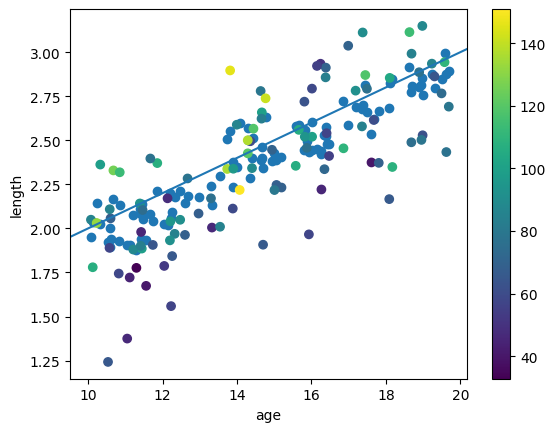

In [21]:
plt.scatter(age, mean_length)
plt.scatter(age, length, c=food)
plt.xlabel("age"); plt.ylabel("length")
plt.axline((10, 2), slope=.1) # mean size at 100% food
plt.colorbar();

## do inference

We'd like to infer age based on length.
The line that minimizes mean squared error
has slope $\sd(Y)/\sd(X) \times \cor[X, Y]$,
and has the right mean.

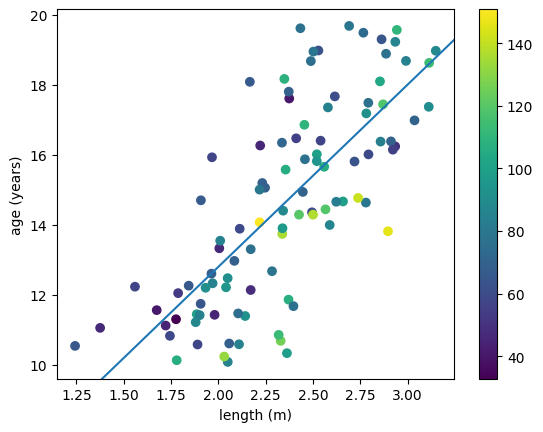

In [28]:
est_slope = np.std(age) * np.corrcoef(age, length)[0,1] / np.std(length)
est_intercept = np.mean(age) - np.mean(length) * est_slope

plt.scatter(length, age, c=food)
plt.ylabel("age (years)"); plt.xlabel("length (m)")
plt.axline((np.mean(length), np.mean(age)), slope=est_slope)
plt.colorbar();

How can we answer the question "how *well* can we estimate age, based on length"?
One answer to this is the *root mean squared error*:

In [29]:
est_age = est_intercept + est_slope * length
residuals = age - est_age
rmsqe = np.sqrt( np.mean(residuals**2) )
print(f"RMSE = {rmsqe} years")

RMSE = 1.8836310356624608 years


In [30]:
np.corrcoef(age, length)

array([[1.        , 0.74655906],
       [0.74655906, 1.        ]])

## Use more variables

Now let's use food availability also!

In [37]:
x = np.vstack((
    np.repeat(1, n),  # for an intercept
    length,
    food
)).T

In [38]:
x.shape

(100, 3)

We know that $b$ solves
$$ (x^T x) b = x^T y .$$

In [41]:
b = np.linalg.solve(x.T.dot(x), x.T.dot(age))

In [42]:
b

array([ 3.39338963,  5.69963281, -0.02654091])

This tells us that estimate age is (roughly)
3.4 years plus 5.7 times the length (in meters) minus .02 times the food availability (in percent).

In [43]:
pred_age = x.dot(b)

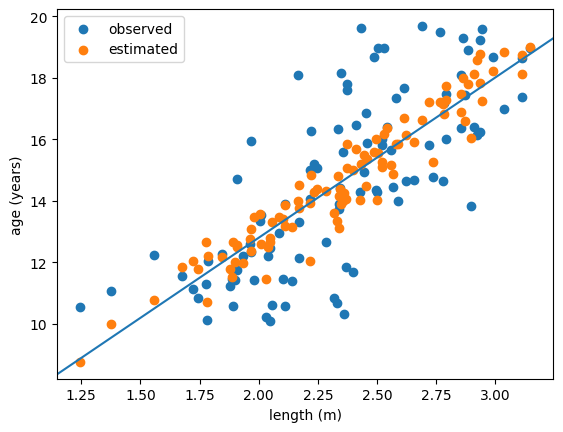

In [44]:
plt.scatter(length, age, label='observed')
plt.scatter(length, pred_age, label='estimated')
plt.ylabel("age (years)"); plt.xlabel("length (m)")
plt.axline((np.mean(length), np.mean(age)), slope=est_slope)
plt.legend();

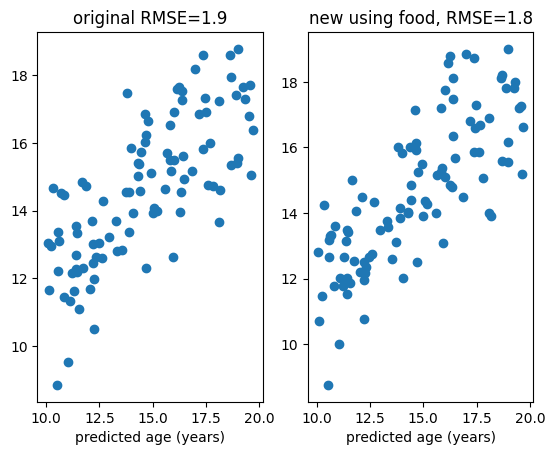

In [48]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.scatter(age, est_age) 
ax0.set_title(f"original RMSE={np.sqrt(np.mean((age - est_age)**2)):.1f}")
ax1.scatter(age, pred_age) 
ax1.set_title(f"new using food, RMSE={np.sqrt(np.mean((age - pred_age)**2)):.1f}")
for ax in (ax0, ax1):
    ax.set_xlabel("observed age (years)")
    ax.set_xlabel("predicted age (years)")